In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
from collections import Counter
np.set_printoptions(suppress=True)

/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
class Estimate:
    def __init__(self, samples):
        self.samples = samples
        self.K = 36
        self.S = len(self.samples)
        self.observed = dict(Counter(self.samples))
        self.ff = dict(Counter(self.observed.values()))

    def chao_estimates(self):  
        if 1 in self.ff and self.ff[1] == self.S:
            return [float('Inf'),float('Inf'),float('Inf')]
        turing_est = 1
        if 1 in self.ff and 2 in self.ff:
            turing_est = 1 - float(self.ff[1] / float(self.S))
            #turing_est = 1 - (float(self.ff[1] / float(self.S)))*(((float(self.S)-1) * self.ff[1])/ (((float(self.S)-1) * self.ff[1]) + 2* self.ff[1]))
            
        N1 = len(self.observed) / turing_est
        #print(">>", len(self.samples), self.ff[1], turing_est)
        tmp = 0.0
        for i in range(1, self.S + 1):
            if i in self.ff:
                tmp += i * (i-1) * self.ff[i]
        cv_est = max(0.0, ((N1 * tmp) / float(self.S * (self.S-1))) - 1)
        cv_2 = max(0.0, cv_est * ( 1+ ((self.S * (1-turing_est) * tmp) / float(self.S * (self.S-1) * turing_est)) ) )
        N2 = N1  + ( self.S * ( (1 - turing_est) / turing_est ) * cv_est )
        N3 = N1  + ( self.S * ( (1 - turing_est) / turing_est ) * cv_2 )
        return [N1, N2, N3]
    
    def chaolow(self):  
        return len(self.observed) + (self.ff[1] ** 2 / (2*self.ff[2]))

    def jack_estimates(self, order = 1):
        J1 = len(self.observed) + \
            ( ( float ((self.K -1) / self.K) * self.ff[1]) if 1 in self.ff else 0 )
        J2 = len(self.observed) + \
            ( ((2*self.K - 3) * self.ff[1] / self.K ) if 1 in self.ff else 0 ) - \
            ( ((self.K-2)**2 * self.ff[2] / ((self.K - 1) * self.K)) if 2 in self.ff else 0 )
        return [J1, J2]

In [6]:
Estimate(sample).chao_estimates(), Estimate(sample).jack_estimates() , Estimate(sample).chaolow()

NameError: name 'sample' is not defined

In [7]:
len(sample)

NameError: name 'sample' is not defined

In [8]:
# Load the data and process it.

df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
#data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

In [9]:
max(df['period'])

35

In [10]:
sample = df[['worker_id', 'period']].drop_duplicates().worker_id.values

In [11]:
Counter(Counter(sample).values())

Counter({2: 6905,
         1: 30424,
         25: 31,
         13: 126,
         3: 2879,
         5: 1033,
         4: 1569,
         8: 372,
         11: 185,
         12: 192,
         7: 480,
         10: 221,
         16: 83,
         6: 685,
         9: 284,
         26: 22,
         20: 66,
         14: 114,
         28: 10,
         23: 29,
         19: 43,
         18: 58,
         31: 6,
         32: 5,
         15: 90,
         30: 8,
         24: 31,
         29: 10,
         17: 83,
         22: 37,
         33: 4,
         21: 38,
         27: 22})

In [3]:
data

,count,max,min
index,,,
0,12,34,19
1,1,21,21
2,1,16,16
3,2,23,12
4,1,18,18
5,2,8,1
6,1,0,0
7,3,24,19
8,1,20,20


In [14]:
Counter(data['count'].values)

Counter({12: 192,
         1: 30424,
         2: 6905,
         3: 2879,
         6: 685,
         5: 1033,
         16: 83,
         4: 1569,
         9: 284,
         8: 372,
         11: 185,
         17: 83,
         7: 480,
         13: 126,
         21: 38,
         10: 221,
         14: 114,
         15: 90,
         18: 58,
         27: 22,
         23: 29,
         20: 66,
         30: 8,
         25: 31,
         19: 43,
         22: 37,
         26: 22,
         33: 4,
         24: 31,
         28: 10,
         32: 5,
         29: 10,
         31: 6})

In [21]:
sc = 1 - (30424/46145)

In [22]:
46145/ sc

135446.9197252083

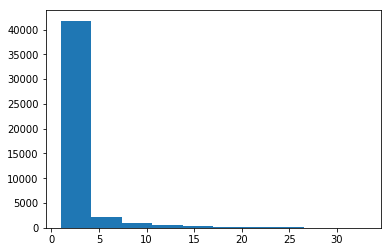

In [23]:
plt.hist(data['count'].values);